In [1]:
%load_ext lab_black

In [2]:
import os
import itertools
from multiprocessing.pool import ThreadPool

import numpy as np
import ee
import pandas as pd
import tqdm
import folium
from tqdm.contrib.concurrent import process_map
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,`
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

In [ ]:
ee.Authenticate()

In [3]:
ee.Initialize()

In [4]:
path = os.path.join("/home", "augusto", "Github", "DesafioAgTech2020")
os.chdir(path)

In [5]:
etiquetas = pd.read_csv(path + "/dataset/Etiquetas.csv")
train = pd.read_csv(path + "/dataset/data_train.csv")
test = pd.read_csv(path + "/dataset/data_test.csv")

In [6]:
train = pd.merge(train, etiquetas, on="Cultivo")
train["Tipo"] = train["Tipo"].apply(
    lambda x: x.replace(" ", "_").replace(",", "").lower()
)

In [7]:
def split_years(campania):
    start_year, end_year = tuple(campania.split("/"))
    return "20" + start_year, "20" + end_year

In [8]:
train["start_year"], train["end_year"] = zip(*train["Campania"].map(split_years))
test["start_year"], test["end_year"] = zip(*test["Campania"].map(split_years))

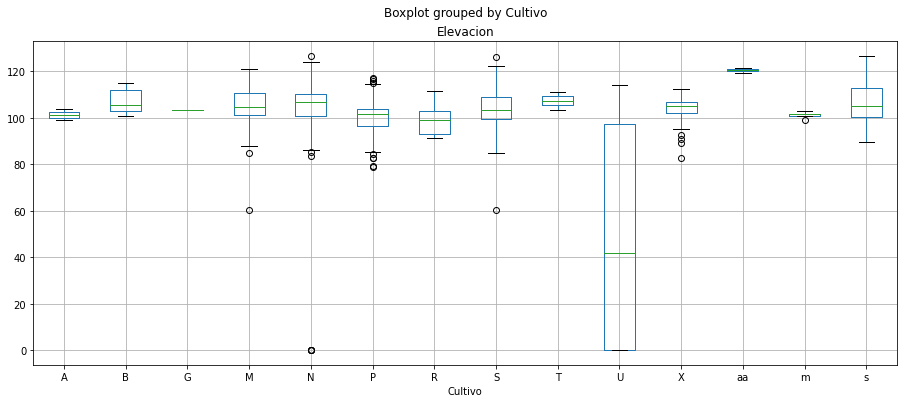

In [13]:
train.boxplot(column=["Elevacion"], by="Cultivo", figsize=(15, 6))

Eliminamos las observaciones con etiqueta "no_sabe" dado que no aportan ningun tipo de informacion

In [67]:
train_filtered = train.query("Tipo not in ('girasol')")

X_train, X_valid, y_train, y_valid = train_test_split(
    train_filtered.drop("Tipo", axis=1),
    train_filtered["Tipo"],
    stratify=train_filtered["Tipo"],
    test_size=0.5,
)

train_dataset = X_train.copy()
train_dataset["Tipo"] = y_train
train_dataset.reset_index(drop=True, inplace=True)
valid_dataset = X_valid.copy()
valid_dataset["Tipo"] = y_valid
valid_dataset.reset_index(drop=True, inplace=True)

train_dataset.loc[len(train_dataset) + 1] = train.query("Tipo == 'girasol'").iloc[
    0
]  # Agrego girasol


X_train, X_valid, y_train, y_valid = train_test_split(
    train_filtered.drop("Tipo", axis=1),
    train_filtered["Tipo"],
    stratify=train_filtered["Tipo"],
    test_size=0.5,
)

train_dataset = X_train.copy()
train_dataset["Tipo"] = y_train
train_dataset.reset_index(drop=True, inplace=True)
valid_dataset = X_valid.copy()
valid_dataset["Tipo"] = y_valid
valid_dataset.reset_index(drop=True, inplace=True)

train_dataset.loc[len(train_dataset) + 1] = train.query("Tipo == 'girasol'").iloc[
    0
]  # Agrego girasol

In [12]:
def get_coord_bands(long, lat, start_year, end_year, scale=10):
    generate_request = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(ee.Geometry.Point(long, lat))
        .filterDate(f"{start_year}-12-15", f"{end_year}-03-15")
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)
        .reduce(ee.Reducer.mean())
        .reduceRegion(ee.Reducer.mean(), ee.Geometry.Point(long, lat), scale=scale)
    )
    pixel_bands = generate_request.getInfo()
    return pixel_bands

In [13]:
def get_bands_info(row):
    latitud = row["Latitud"]
    longitud = row["Longitud"]
    bands = get_coord_bands(
        long=longitud,
        lat=latitud,
        start_year=row["start_year"],
        end_year=row["end_year"],
    )
    data = {
        "latitud": latitud,
        "longitud": longitud,
        "elevacion": row["Elevacion"],
        "cultivo": row["CultivoId"],
        "etiqueta": row["Tipo"],
        **bands,
    }
    return data

In [14]:
def data_augmentation(row, start=-0.0005, end=0.0005, offset=0.0001):
    new_obs = []
    for lat_offset in np.arange(start, end, offset):
        for long_offset in np.arange(start, end, offset):
            image_type = (
                "original" if (long_offset == 0 and lat_offset == 0) else "augmented"
            )
            latitud = row["Latitud"] + lat_offset
            longitud = row["Longitud"] + long_offset
            bands = get_coord_bands(
                long=longitud,
                lat=latitud,
                start_year=row["start_year"],
                end_year=row["end_year"],
            )
            data = {
                "latitud": latitud,
                "longitud": longitud,
                "elevacion": row["Elevacion"],
                **bands,
                "cultivo": row["CultivoId"],
                "etiqueta": row["Tipo"],
                "imagen": image_type,
            }
            new_obs.append(data)
    return new_obs

In [48]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
sep = pd.merge(
    train_augmented.rename(columns={"latitud": "Latitud", "longitud": "Longitud"}),
    train,
    on=["Latitud", "Longitud"],
    how="right",
)

valid_dataset = sep[sep["AOT_mean"].isna()].dropna(axis=1)

In [229]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
sep = pd.merge(
    train_augmented.rename(columns={"latitud": "Latitud", "longitud": "Longitud"}),
    train,
    on=["Latitud", "Longitud"],
    how="right",
)

In [88]:
thread_pool = ThreadPool(8)
info = train_dataset.to_dict(orient="records")
data = thread_pool.map(data_augmentation, info)

In [93]:
train_augmented = pd.DataFrame(list(itertools.chain.from_iterable(data)))
train_augmented.to_csv("train_v4_augmented.csv", index=False)

In [ ]:
valid_info = valid_dataset.to_dict(orient="records")
data_valid = thread_pool.map(data_augmentation, valid_info)
valid_augmented = pd.DataFrame(list(itertools.chain.from_iterable(data_valid)))
valid_augmented.to_csv("valid_v3_augmented.csv", index=False)

In [ ]:
train_augmented.boxplot([col for col in train_augmented if col.startswith('B')], by="etiqueta", figsize=(15,6));

In [53]:
def process_features(dataset, label=None):
    df = dataset.copy()
    df["NDVI_mean"] = (df["B8_mean"] - df["B4_mean"]) / (df["B8_mean"] + df["B4_mean"])
    df["GNDVI_mean"] = (df["B8_mean"] - df["B3_mean"]) / (df["B8_mean"] + df["B3_mean"])
    df["SAVI_mean"] = (
        (df["B8_mean"] - df["B4_mean"])
        / (df["B8_mean"] + df["B4_mean"] + 0.428)
        * (1.428)
    )
    df["NDMI_mean"] = (df["B8_mean"] - df["B11_mean"]) / (
        df["B8_mean"] + df["B11_mean"]
    )
    df["MSI_mean"] = df["B11_mean"] / df["B8_mean"]
    df["GCI_mean"] = (df["B9_mean"] / df["B3_mean"]) - 1
    df["BSI_mean"] = (
        (df["B11_mean"] + df["B4_mean"]) - (df["B8_mean"] + df["B2_mean"])
    ) / ((df["B11_mean"] + df["B4_mean"]) + (df["B8_mean"] + df["B2_mean"]))
    for value in np.arange(0, 1.0, 0.4):
        df[f"NDVI_mean<{value}"] = np.where(df["NDVI_mean"] < value, 1, 0)
    X_cols = [col for col in df if col.endswith("mean")] + ["elevacion"]
    X = df[X_cols]
    y = np.array(df[label]) if label else None
    return X, y

In [ ]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 1.2)
    upper_limit = s.mean() + (s.std() * 1.2)
    return ~s.between(lower_limit, upper_limit)

In [244]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
valid_augmented = pd.read_csv("valid_v4_augmented.csv")

In [221]:
train_augmented = train_augmented.query("cultivo != 23")
valid_augmented = valid_augmented.query("cultivo != 23")

In [248]:
train_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)
valid_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)